In [1]:
import numpy as np
import os
import json
import random
import shutil

from PIL import Image

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
print(tf.__version__)
# verify if cuda is available
print(tf.test.is_built_with_cuda())
# show devices
print(tf.config.list_physical_devices('GPU'))

2.8.4
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


In [3]:
dataset_is_split = False

In [4]:
annotations = '/home/enzo.viacava/annotations/instances_default.json'

with open(annotations) as f:
    data = json.load(f)

In [5]:
# Size of the dataset
size = len(data['images'])
print('Number of images in the dataset: ', size)

Number of images in the dataset:  69


In [6]:
# labels map as a dictionary (zero is reserved)
label_map = {category['id']: category['name'] for category in data['categories']}

In [7]:
if dataset_is_split:
  # If dataset is already split, specify each path:
  train_images_dir = 'dataset/train/images'
  train_annotations_dir = 'dataset/train/annotations'
  val_images_dir = 'dataset/validation/images'
  val_annotations_dir = 'dataset/validation/annotations'
  test_images_dir = 'dataset/test/images'
  test_annotations_dir = 'dataset/test/annotations'
else:
  # If it's NOT split yet, specify the path to all images and annotations
  images_in = '/home/enzo.viacava/jpg/images'
  annotations_in = '/home/enzo.viacava/pascal_voc'

In [8]:
def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  # _, dirs, _ = next(os.walk(images_path))

  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

In [9]:
# Create DataLoader objects for each split
if dataset_is_split:
  train_data = object_detector.DataLoader.from_pascal_voc(
      train_images_dir, train_annotations_dir, label_map=label_map)
  validation_data = object_detector.DataLoader.from_pascal_voc(
      val_images_dir, val_annotations_dir, label_map=label_map)
  test_data = object_detector.DataLoader.from_pascal_voc(
      test_images_dir, test_annotations_dir, label_map=label_map)
else:
  train_dir, val_dir, test_dir = split_dataset(images_in, annotations_in,
                                                val_split=0.2, test_split=0.2,
                                                out_path='split-dataset')

In [10]:
train_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(train_dir, 'images'),
    os.path.join(train_dir, 'annotations'), label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(val_dir, 'images'),
    os.path.join(val_dir, 'annotations'), label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(test_dir, 'images'),
    os.path.join(test_dir, 'annotations'), label_map=label_map)
    
print(f'train count: {len(train_data)}')
print(f'validation count: {len(validation_data)}')
print(f'test count: {len(test_data)}')

train count: 43
validation count: 13
test count: 13


In [11]:
# Object detector model specification
spec = object_detector.EfficientDetLite0Spec()

2024-09-02 13:14:22.789682: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 13:14:29.384256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 34812 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-09-02 13:14:29.388089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38226 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-09-02 13:14:29.391549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/devi

In [12]:
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               validation_data=validation_data, 
                               epochs=50, 
                               batch_size=10, 
                               train_whole_model=True)

Epoch 1/50


2024-09-02 13:15:16.091495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


4/4 [==============================] - 35s 2s/step - det_loss: 2.4823 - cls_loss: 1.1881 - box_loss: 0.0259 - reg_l2_loss: 0.0632 - loss: 2.5455 - learning_rate: 0.0100 - gradient_norm: 2.5548 - val_det_loss: 2.4856 - val_cls_loss: 1.1700 - val_box_loss: 0.0263 - val_reg_l2_loss: 0.0632 - val_loss: 2.5488
Epoch 2/50
4/4 [==============================] - 4s 1s/step - det_loss: 2.3504 - cls_loss: 1.1634 - box_loss: 0.0237 - reg_l2_loss: 0.0632 - loss: 2.4136 - learning_rate: 0.0125 - gradient_norm: 1.7892 - val_det_loss: 2.4065 - val_cls_loss: 1.1422 - val_box_loss: 0.0253 - val_reg_l2_loss: 0.0632 - val_loss: 2.4696
Epoch 3/50
4/4 [==============================] - 5s 2s/step - det_loss: 2.3576 - cls_loss: 1.1329 - box_loss: 0.0245 - reg_l2_loss: 0.0632 - loss: 2.4208 - learning_rate: 0.0124 - gradient_norm: 1.4920 - val_det_loss: 2.3144 - val_cls_loss: 1.0953 - val_box_loss: 0.0244 - val_reg_l2_loss: 0.0632 - val_loss: 2.3776
Epoch 4/50
4/4 [==============================] - 4s 1s/ste

In [13]:
model.evaluate(test_data)

1/1 [==============================] - 4s 4s/step



{'AP': 0.18138117,
 'AP50': 0.28100368,
 'AP75': 0.20568508,
 'APs': 0.0,
 'APm': 0.0,
 'APl': 0.27207175,
 'ARmax1': 0.2,
 'ARmax10': 0.22727273,
 'ARmax100': 0.22727273,
 'ARs': 0.0,
 'ARm': 0.0,
 'ARl': 0.3409091,
 'AP_/Fecal': 0.0,
 'AP_/Biliar': 0.0,
 'AP_/Pieza': 0.5441435}

In [14]:
TFLITE_FILENAME = 'efficientdet-lite-matadero.tflite'
LABELS_FILENAME = 'matadero.txt'

In [15]:
weights_folder = 'weights'
os.makedirs(weights_folder, exist_ok=True)
model.export(export_dir=weights_folder, tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

2024-09-02 13:19:40.443227: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2024-09-02 13:20:05.290694: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


Estimated count of arithmetic ops: 1.756 G  ops, equivalently 0.878 G  MACs


2024-09-02 13:20:11.236619: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-09-02 13:20:11.236685: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-09-02 13:20:11.237918: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp3wgoa16g
2024-09-02 13:20:11.372315: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-09-02 13:20:11.372389: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp3wgoa16g
2024-09-02 13:20:11.777749: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-09-02 13:20:13.544718: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp3wgoa16g
2024-09-02 13:20:14.303646: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 3065729

Estimated count of arithmetic ops: 1.756 G  ops, equivalently 0.878 G  MACs


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0
2024-09-02 13:20:28.794829: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 1.756 G  ops, equivalently 0.878 G  MACs



In [16]:
model.evaluate_tflite(os.path.join(weights_folder, TFLITE_FILENAME), test_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


13/13 [==============================] - 25s 2s/step



{'AP': 0.17066544,
 'AP50': 0.28162375,
 'AP75': 0.15577558,
 'APs': 0.0,
 'APm': 0.0,
 'APl': 0.25599816,
 'ARmax1': 0.19090909,
 'ARmax10': 0.2060606,
 'ARmax100': 0.2060606,
 'ARs': 0.0,
 'ARm': 0.0,
 'ARl': 0.3090909,
 'AP_/Fecal': 0.0,
 'AP_/Biliar': 0.0,
 'AP_/Pieza': 0.5119963}

In [50]:
# take a random image from the test set:
images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
filenames = os.listdir(os.path.join(images_path))
random_index = random.randint(0,len(filenames)-1)
INPUT_IMAGE = os.path.join(images_path, filenames[random_index])

Image: 2023-12-14_11-46-58-0530.jpg


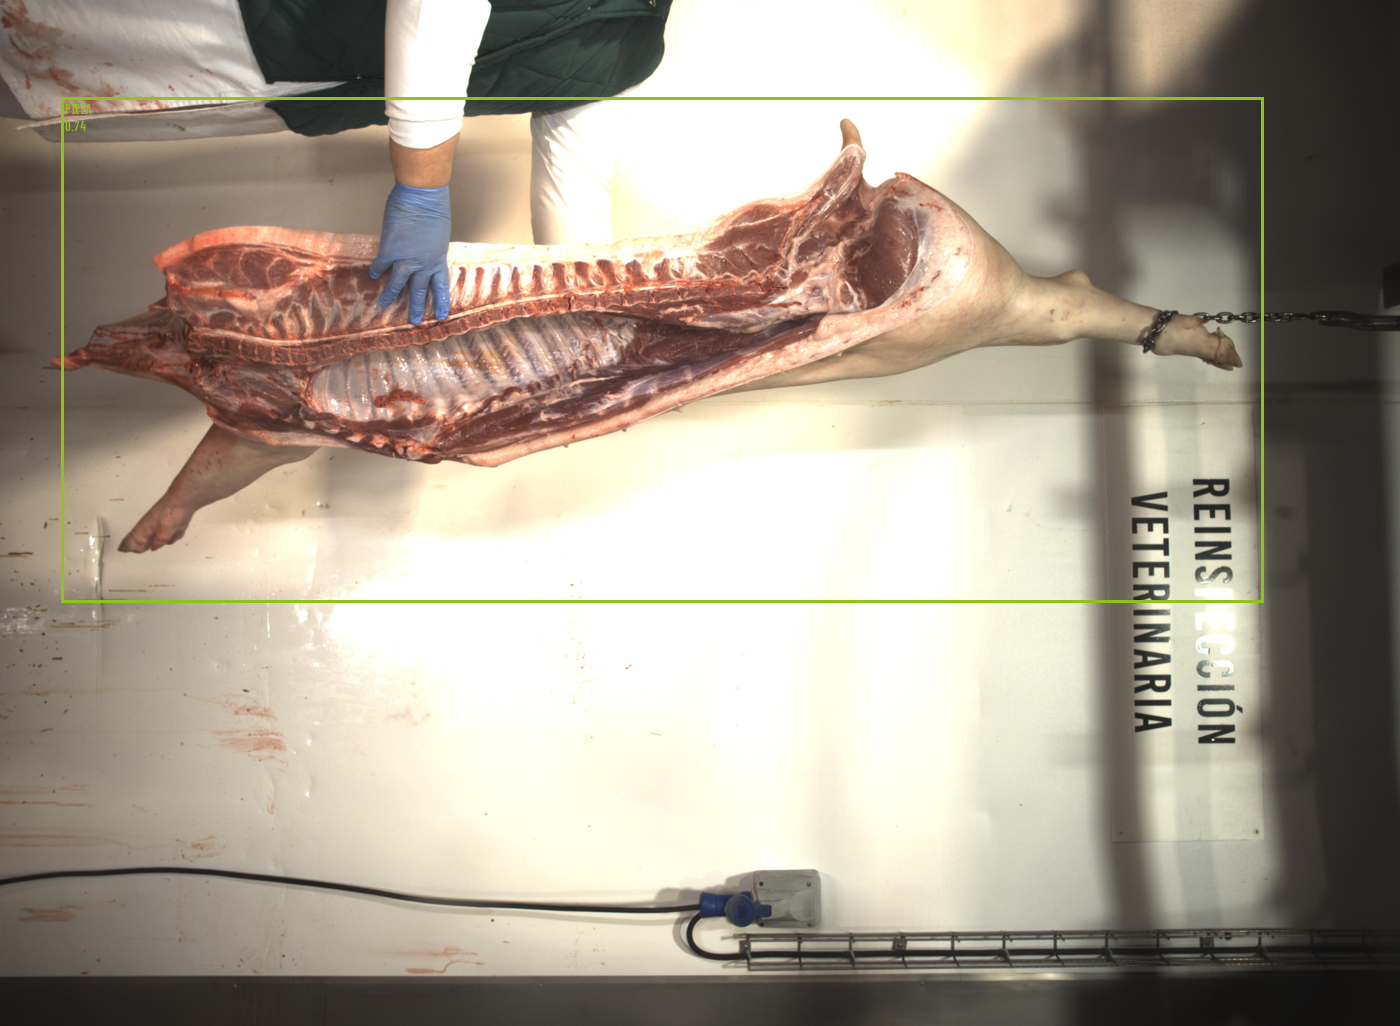

In [51]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("AlegreSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(os.path.join(weights_folder, LABELS_FILENAME))
interpreter = tflite.Interpreter(os.path.join(weights_folder, TFLITE_FILENAME))
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.2, image_scale=scale)
600
# Resize again to a reasonable size for display
display_width = 1400
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
print('Image:', INPUT_IMAGE.split('/')[-1])
image

In [54]:
model_list = os.listdir(weights_folder)

In [56]:
model_name = model_list[3]
print(model_name)

efficientdet-lite-matadero_epoch_1000_bs_43.tflite


Image: 2023-12-14_11-46-58-0530.jpg


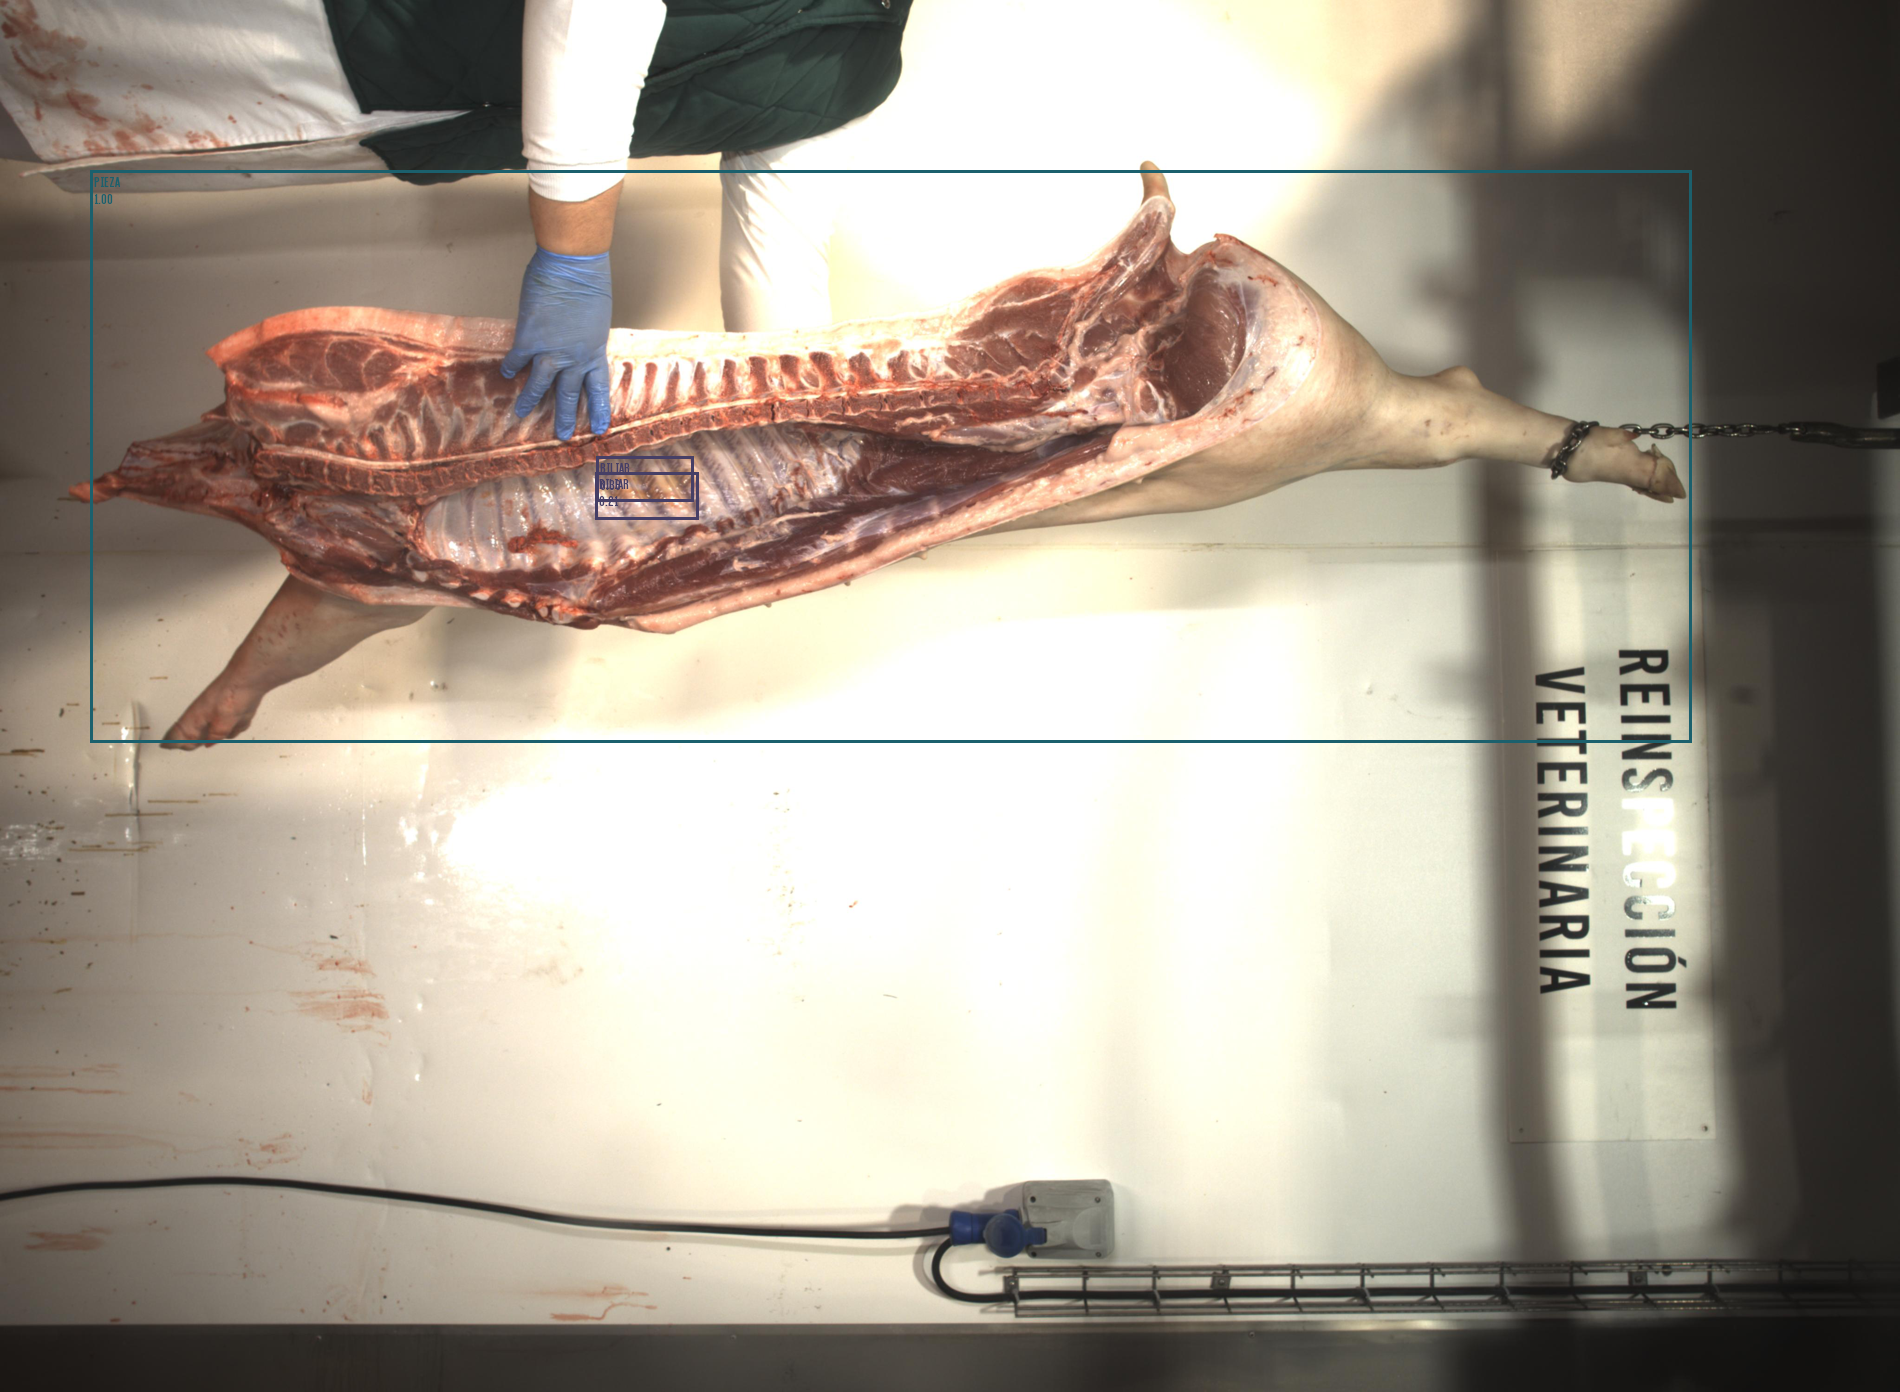

In [63]:
# Load the TF Lite model
interpreter = tflite.Interpreter(os.path.join(weights_folder, model_name))
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.2, image_scale=scale)

# Resize again to a reasonable size for display
display_width = 1900
scale_factor = display_width / image.width
height_ratio = image.height / image.width

image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
print('Image:', INPUT_IMAGE.split('/')[-1])
image
